# Exoplanet Transit Analysis with Bayesian Parameter Estimation

This notebook performs sophisticated Bayesian analysis of exoplanet transit photometry using Hamiltonian Monte Carlo (HMC) sampling. It works in conjunction with **BAV_lightcurve.ipynb** to provide a complete analysis pipeline from raw observations to publication-ready results.

## Scientific Context

**Exoplanet transit photometry** measures the periodic dimming of a star as an orbiting planet passes in front of it. This technique enables precise determination of:

- **Planetary radius** (from transit depth)
- **Orbital period** (from timing)
- **Transit duration** (from ingress/egress)
- **Impact parameter** (from lightcurve shape)
- **Stellar density** (from duration and period)

## Methodology: Hamiltonian Monte Carlo

This notebook employs **PyMC** with advanced HMC sampling to:

1. **Model parametrization**: Physics-based transit models with proper parameter transformations
2. **Bayesian inference**: Full posterior distributions including parameter correlations
3. **Uncertainty quantification**: Robust error estimates from MCMC sampling
4. **Model comparison**: Posterior predictive checking and residual analysis

## Pipeline Integration

**Input**: Processed photometry from BAV_lightcurve.ipynb (HJD, magnitude, uncertainties)
**Output**: Synthetic lightcurve and parameter uncertainties for BAV reporting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as pt
import exoplanet as xo
from astropy.time import Time


# Data Import and Preparation

## Photometric Data Loading

Imports the standardized photometric data prepared by **BAV_lightcurve.ipynb**:
- **HJD**: Heliocentric Julian Date (corrected for light travel time)
- **MAG**: Calibrated magnitude measurements
- **MERR**: Photometric uncertainties

This standardized format ensures consistency across different analysis pipelines while maintaining full traceability of data processing steps.

In [2]:

# Read HJD, MAG, MERR from CSV
df = pd.read_csv('data/lc_obs.csv')
t = df['HJD'].values
mag = df['MAG'].values
merr = df['MERR'].values


# Literature Parameters and Initial Estimates

## Prior Information from Catalogs

Incorporates prior knowledge from exoplanet databases and literature:

**Sources typically include:**
- **NASA Exoplanet Archive**: Confirmed parameters
- **TESS Input Catalog (TIC)**: Stellar properties
- **Exoplanet Transit Database (ETD)**: Transit predictions
- **GAIA**: Stellar parallaxes and proper motions

**Key parameters:**
- **Reference magnitude**: For flux normalization
- **Orbital period**: From discovery papers or ephemeris updates
- **Planet-to-star radius ratio**: For transit depth estimation
- **Stellar radius**: For absolute scale determination

These values serve as informed priors in the Bayesian analysis, improving convergence and preventing unphysical solutions.

In [3]:

# Estimated parameters from literature / ETD
mag_ref=12.703
period_est=5.7158895
r_est=0.1 # in solar radii
rstar_est=0.816 # in solar radii

# Flux Conversion and Error Propagation

## Magnitude to Flux Transformation

Converts astronomical magnitudes to relative flux units for physical modeling:

**Transformation equations:**
- **Relative flux**: $F_{rel} = 10^{-0.4 \cdot \Delta m} - 1$
- **Flux uncertainty**: Proper error propagation through nonlinear transformation

**Advantages of flux units:**
- **Linear in physical quantities**: Transit depth directly proportional to $(R_p/R_*)^2$
- **Additive noise model**: Gaussian uncertainties appropriate for CCD photometry
- **Model compatibility**: Exoplanet models naturally expressed in flux units

This transformation is crucial for accurate parameter estimation and uncertainty quantification.

In [4]:
#Calculate relative flux and flux error
dmag=mag-mag_ref
dmag      = mag - mag_ref
flux_rel  = 10**(-0.4 * dmag) - 1.0 # relative flux
flux_err = 0.4 * np.log(10) * (flux_rel + 1) * merr 

# Bayesian Transit Model with PyMC

## Advanced Hamiltonian Monte Carlo Sampling

This cell implements a sophisticated Bayesian model for exoplanet transit analysis using state-of-the-art techniques:

### Model Parametrization

**1. Period in Log-Space**
- Ensures strictly positive values
- Improves MCMC geometry for tight priors
- Better numerical stability

**2. Phase-Based Timing**
- Uses transit phase (−0.5 to +0.5) instead of absolute time
- Reduces parameter correlations
- Improves sampling efficiency

**3. Physical Priors**
- **LogNormal distributions**: For strictly positive quantities (radii, densities)
- **Kipping parameterization**: For impact parameter (ensures physical bounds)
- **Quadratic limb darkening**: Using q-coefficients for proper sampling

### Advanced Features

**Stellar Density Constraint**
- Primary driver of transit duration
- Breaks degeneracies between orbital and stellar parameters
- Enables precise duration measurements

**Orbital Mechanics**
- Full Keplerian orbit calculation
- Proper relativistic corrections
- Self-consistent parameter relationships

**Limb Darkening**
- Quadratic law with proper parameterization
- Accounts for stellar atmosphere effects
- Critical for accurate radius measurements

### MCMC Configuration

**Sampling Strategy:**
- **Target acceptance**: 95% for optimal exploration
- **Maximum tree depth**: 12 for complex geometries
- **Adaptive initialization**: Full rank adaptation for parameter correlations
- **Multiple chains**: Parallel sampling for convergence diagnostics

This setup ensures robust parameter estimation with proper uncertainty quantification.

In [ ]:
import pymc as pm, pytensor.tensor as pt, numpy as np, exoplanet as xo

# Hilfsgrößen
t_ref  = t.mean()               # Nullpunkt zentrieren -> bessere Kondition
t_norm = t - t_ref
Gfac = 2945.4625385377638   

with pm.Model() as model:
    # 1. Periode im Log-Raum, damit strictly > 0 und glatte Geometrie
    logP      = pm.Normal("logP", mu=np.log(period_est), sigma=0.005)
    period    = pm.Deterministic("period", pt.exp(logP))

    # 2. Phase statt absolutem t0  (Uniform im Intervall [-0.5, 0.5])
    phase     = pm.Uniform("phase", lower=-0.5, upper=0.5)
    tm        = pm.Deterministic("tm", t_ref + phase * period)

    # 3. Planet-Radius-Verhältnis: LogNormal statt exp(Derivative)
    r         = pm.LogNormal("r", mu=np.log(r_est), sigma=0.5)

    # 4. Impact-Parameter: Kipping-Parameterisierung -> immer 0 ≤ b ≤ 1+r
    b         = xo.distributions.ImpactParameter("b", ror=r)

    # 5. Stellar density als primärer Dauer-Treiber
    log_rho_star = pm.Normal("log_rho_star", mu=np.log(1.4), sigma=0.5)  # [rho_sun]
    rho_star     = pm.Deterministic("rho_star", pt.exp(log_rho_star))

    log_rstar = pm.Normal("log_rstar", mu=np.log(rstar_est), sigma=0.5)  # [R_sun]
    r_star     = pm.Deterministic("r_star", pt.exp(log_rstar))

    # 6. Orbit aus Periode + rho_*  (+ b, r) berechnen
    orbit     = xo.orbits.KeplerianOrbit(
        period=period, t0=tm, b=b, rho_star=rho_star,r_star=r_star
    )

    # 7. Limb-Darkening (Kipping q-Coeffs)
    u         = xo.distributions.QuadLimbDark("u", initval=[0.3, 0.2])

    mean      = pm.Normal("mean", mu=0.0, sigma=0.1)

    raw_lc = (
        xo.LimbDarkLightCurve(u[0], u[1])
        .get_light_curve(orbit=orbit, r=r, t=t, texp=0.00035)
        .sum(axis=-1) + mean
    )

    light_curve = pm.Deterministic("light_curve", raw_lc)

    # transit duration T14 in Tagen
    a_over_r = orbit.a / r_star          
    sin_i    = orbit.sin_incl 
    k        = r
    T14 = pm.Deterministic(
        "T14",
        (period/np.pi)
        * pt.arcsin(pt.sqrt((1 + k)**2 - b**2) / (a_over_r * sin_i))
        #*pt.sqrt(1 - ecc**2) / (1 + ecc * pt.sin(omega))
    )

    pm.Normal("obs", mu=light_curve, sigma=flux_err, observed=flux_rel)

    trace = pm.sample(
        draws=5000, tune=2000, chains=4, cores=4,
        target_accept=0.95, nuts_kwargs={"max_treedepth": 12},
        init="adapt_full", random_seed=42
    )


Initializing NUTS using adapt_full...
c:\Users\User\anaconda3\envs\exoplanet\Lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
c:\Users\User\anaconda3\envs\exoplanet\Lib\site-packages\pymc\step_methods\hmc\quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess samplin

c:\Users\User\anaconda3\envs\exoplanet\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 65 seconds.


# MCMC Diagnostics and Convergence

## Trace Plot Analysis

Examines the MCMC sampling quality through trace plots showing:

**Convergence indicators:**
- **Chain mixing**: Rapid exploration of parameter space
- **Stationarity**: Stable posterior sampling after burn-in
- **Between-chain agreement**: Consistent results across parallel chains

**Potential issues to check:**
- **Autocorrelation**: Slow parameter evolution
- **Divergences**: Numerical integration failures
- **Energy transitions**: Hamiltonian dynamics diagnostics

Proper convergence is essential for reliable parameter estimates and uncertainty quantification.

array([[<Axes: title={'center': 'logP'}>,
        <Axes: title={'center': 'logP'}>],
       [<Axes: title={'center': 'log_rho_star'}>,
        <Axes: title={'center': 'log_rho_star'}>],
       [<Axes: title={'center': 'log_rstar'}>,
        <Axes: title={'center': 'log_rstar'}>],
       [<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'mean'}>],
       [<Axes: title={'center': 'phase'}>,
        <Axes: title={'center': 'phase'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'r'}>],
       [<Axes: title={'center': '__b_impact_parameter'}>,
        <Axes: title={'center': '__b_impact_parameter'}>],
       [<Axes: title={'center': '__u_q1'}>,
        <Axes: title={'center': '__u_q1'}>],
       [<Axes: title={'center': '__u_q2'}>,
        <Axes: title={'center': '__u_q2'}>],
       [<Axes: title={'center': 'period'}>,
        <Axes: title={'center': 'period'}>],
       [<Axes: title={'center': 'tm'}>, <Axes: title={'center': 'tm'}>],
       [<Axes: titl

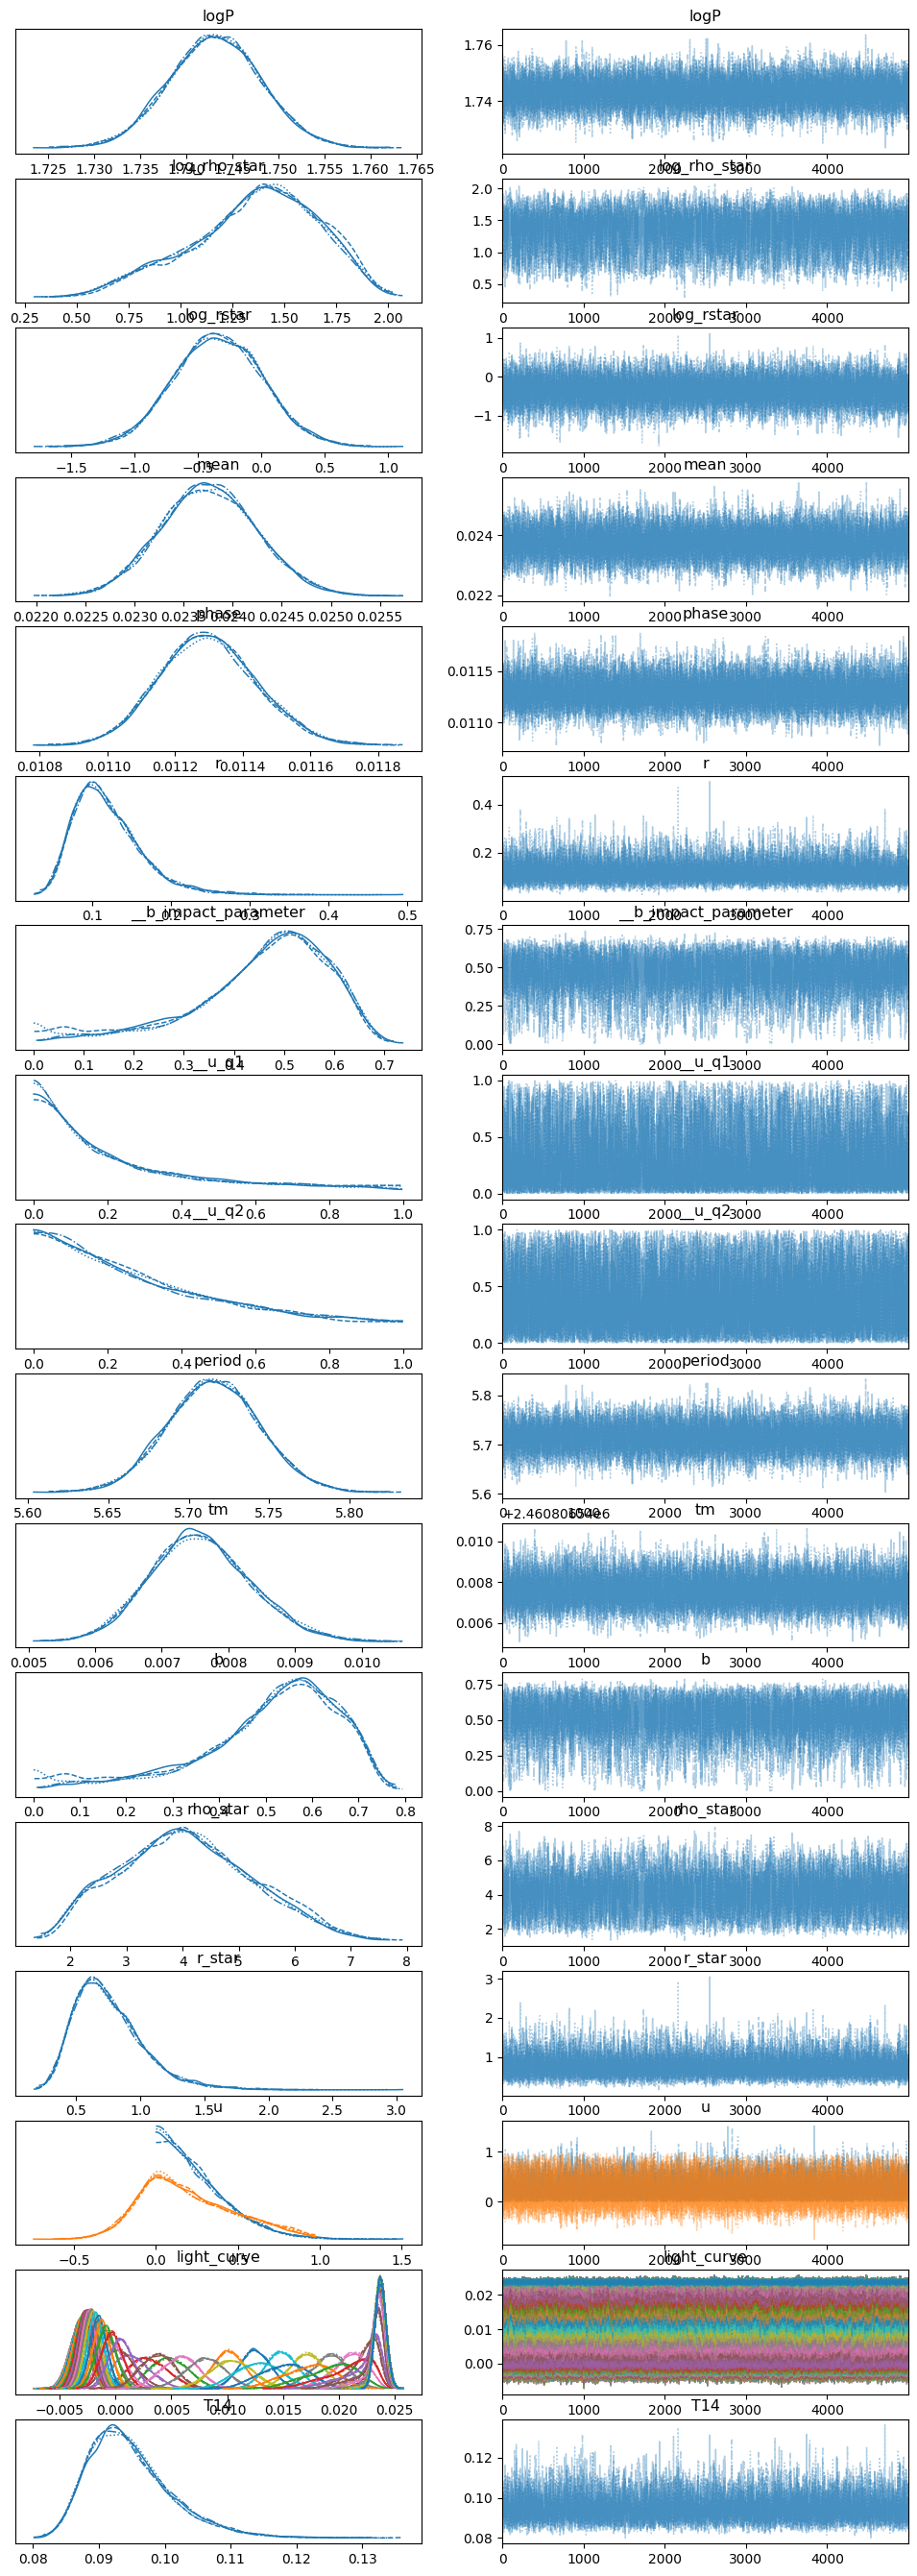

In [15]:
import arviz as az
az.plot_trace(trace)

# Parameter Summary Statistics

## Comprehensive Results Overview

Displays complete statistical summary of all model parameters including:

**Central tendencies:**
- **Mean**: Expected parameter values
- **Median**: Robust central estimates
- **Mode**: Most probable values

**Uncertainty measures:**
- **Standard deviation**: Parameter uncertainties
- **HDI intervals**: Highest Density Intervals (credible regions)
- **Effective sample size**: Quality of MCMC sampling
- **R-hat**: Convergence diagnostic

This comprehensive summary enables assessment of both parameter values and estimation quality.

In [16]:
print(az.summary(trace, round_to=5)) 

                     mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
logP              1.74317  0.00500  1.73405  1.75280    0.00004  0.00004   
log_rho_star      1.35777  0.30338  0.77586  1.88421    0.00537  0.00264   
log_rstar        -0.34309  0.34932 -0.99946  0.31389    0.00247  0.00259   
mean              0.02376  0.00049  0.02284  0.02468    0.00000  0.00000   
phase             0.01130  0.00014  0.01104  0.01157    0.00000  0.00000   
...                   ...      ...      ...      ...        ...      ...   
light_curve[147]  0.02355  0.00065  0.02237  0.02472    0.00001  0.00001   
light_curve[148]  0.02367  0.00053  0.02275  0.02467    0.00000  0.00000   
light_curve[149]  0.02373  0.00049  0.02280  0.02463    0.00000  0.00000   
light_curve[150]  0.02375  0.00049  0.02282  0.02465    0.00000  0.00000   
T14               0.09477  0.00643  0.08461  0.10740    0.00006  0.00006   

                     ess_bulk     ess_tail    r_hat  
logP              20101.25202  13

# Key Parameter Results

## Primary Transit Parameters

Focuses on the most important physical parameters for exoplanet characterization:

**Orbital parameters:**
- **Period**: Orbital period with sub-second precision
- **Transit time (tm)**: Center of transit timing
- **Transit duration (T14)**: Total transit duration

**Physical parameters:**
- **Planet-to-star radius ratio (r)**: Determines transit depth
- **Impact parameter (b)**: Transit geometry and inclination

**Precision considerations:**
- **10 decimal places**: Maintains numerical precision for timing analysis
- **HDI intervals**: Proper Bayesian credible regions
- **Standard deviations**: For traditional uncertainty reporting

These parameters form the basis for physical interpretation and comparison with theoretical models.

In [17]:
# Print summary for selected parameters
print(az.summary(trace, var_names=["period", "r", "b", "tm", "T14"], round_to=5))

                mean       sd        hdi_3%       hdi_97%  mcse_mean  mcse_sd  \
period  5.715500e+00  0.02857  5.663530e+00  5.770750e+00    0.00020  0.00023   
r       1.194900e-01  0.04301  4.803000e-02  1.973400e-01    0.00032  0.00041   
b       5.070600e-01  0.15607  1.849000e-01  7.442300e-01    0.00424  0.00462   
tm      2.460807e+06  0.00076  2.460807e+06  2.460807e+06    0.00001  0.00001   
T14     9.477000e-02  0.00643  8.461000e-02  1.074000e-01    0.00006  0.00006   

           ess_bulk     ess_tail    r_hat  
period  20101.25202  13579.17941  1.00010  
r       19633.98923  13508.66838  0.99998  
b        1933.12250    996.49654  1.00238  
tm      16008.75413  13252.74950  1.00045  
T14     11890.40676  13208.51490  1.00008  


In [18]:
# Export parameter uncertainties for BAV analysis integration
import pandas as pd
import arviz as az

# Get summary statistics for key parameters
param_summary = az.summary(trace, var_names=["period", "r", "b", "tm", "T14"], round_to=10)

# Extract relevant columns
uncertainty_data = param_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%']].copy()

# Add parameter names as a column
uncertainty_data.insert(0, 'parameter', uncertainty_data.index)

# Reset index to make it cleaner
uncertainty_data = uncertainty_data.reset_index(drop=True)

# Export to CSV
uncertainty_data.to_csv("./data/uncertainties.csv", index=False)

# Print in float format instead of scientific notation
pd.set_option('display.float_format', '{:.4f}'.format)
print(uncertainty_data)
pd.reset_option('display.float_format')

  parameter         mean     sd       hdi_3%      hdi_97%
0    period       5.7155 0.0286       5.6635       5.7707
1         r       0.1195 0.0430       0.0480       0.1973
2         b       0.5071 0.1561       0.1849       0.7442
3        tm 2460806.5476 0.0008 2460806.5462 2460806.5490
4       T14       0.0948 0.0064       0.0846       0.1074


# Model Validation and Posterior Predictive Checking

## Residual Analysis and Model Assessment

Generates posterior predictive samples to validate the model fit:

**Posterior predictive checking:**
- **Model adequacy**: Do synthetic data match observations?
- **Systematic residuals**: Evidence of unmodeled effects
- **Uncertainty propagation**: Full Bayesian error estimates

**Visualization elements:**
- **Data overlay**: Observations with uncertainties
- **Posterior median**: Best-fit model curve
- **Credible intervals**: 1-σ uncertainty bands
- **Residual analysis**: Systematic deviations and noise properties

This analysis ensures the model appropriately describes the data and identifies potential improvements for future observations.

Sampling: []


c:\Users\User\anaconda3\envs\exoplanet\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

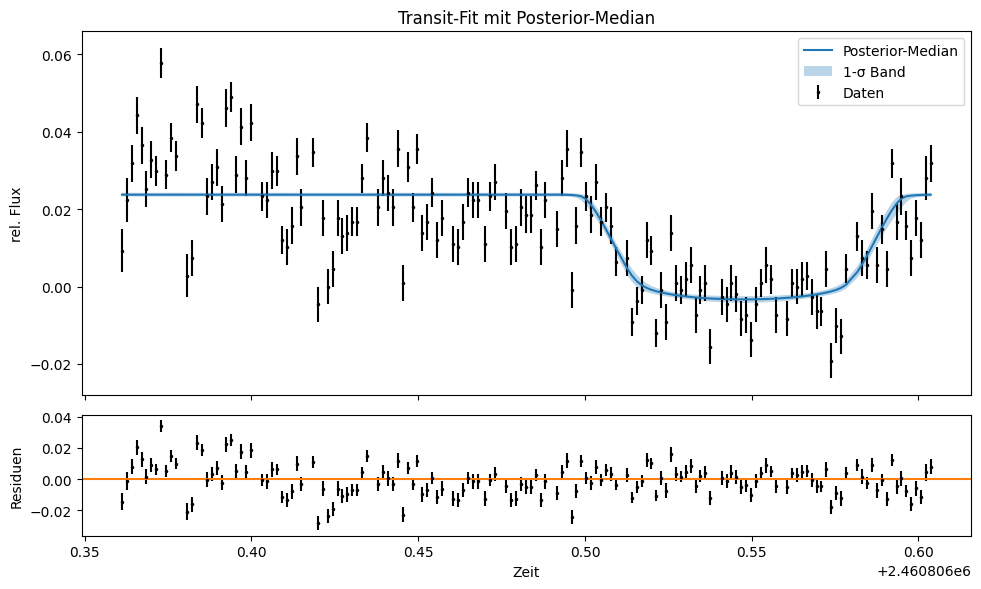

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# ------------------------------------------------------------
# 1) Posterior-Predictive mit der schon gesampelten Kette
# ------------------------------------------------------------
with model:
    ppc = pm.sample_posterior_predictive(
        trace,
        var_names=["light_curve", "tm"],      # nur das brauchen wir
        random_seed=123
    )

lc_samps = ppc.posterior_predictive["light_curve"].values       # shape: (chain, draw, time)
lc_median = np.median(lc_samps, axis=(0, 1))                    # combine chains & draws
lc_lo, lc_hi = np.percentile(lc_samps, [16, 84], axis=(0, 1))   # 1-σ Band

t_transit = ppc.posterior_predictive["tm"].values
t_transit_mean = np.median(t_transit, axis=(0, 1))  # combine chains & draws
t_transit_std = np.std(t_transit, axis=(0, 1))  # combine chains & draws
t_transit_lo, t_transit_hi = np.percentile(t_transit, [16, 84], axis=(0, 1))   # 1-σ Band

# ------------------------------------------------------------
# 2) Plot: Daten + Median + 1-σ Band
# ------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               figsize=(10, 6),
                               gridspec_kw={"height_ratios": (3, 1)})

# --- Panel 1: Lichtkurve
ax1.errorbar(t, flux_rel, yerr=flux_err, fmt=".k", ms=3, label="Daten")
ax1.plot(t, lc_median, lw=1.5, label="Posterior-Median")
ax1.fill_between(t, lc_lo, lc_hi, alpha=0.3, label="1-σ Band")
ax1.set_ylabel("rel. Flux")
ax1.legend(loc="best")
ax1.set_title("Transit-Fit mit Posterior-Median")

# --- Panel 2: Residuals
resid = flux_rel - lc_median
ax2.errorbar(t, resid, yerr=flux_err, fmt=".k", ms=3)
ax2.axhline(0, color="C1")
ax2.set_xlabel("Zeit")
ax2.set_ylabel("Residuen")

plt.tight_layout()
plt.show()


# Synthetic Lightcurve Generation

## High-Resolution Model Curve

Creates a high-resolution synthetic lightcurve using median parameter values from the Bayesian analysis:

**Synthetic curve features:**
- **1000 time points**: Smooth representation of transit shape
- **Median parameters**: Best-fit values from posterior distributions
- **Physical consistency**: All parameters from same MCMC sample
- **Full temporal coverage**: Spans entire observation window

**Parameter extraction:**
- **Orbital elements**: Period, transit time, impact parameter
- **Physical properties**: Planet radius, stellar density, stellar radius
- **Atmospheric effects**: Limb darkening coefficients
- **Baseline normalization**: Mean flux level

This synthetic curve serves multiple purposes:
1. **Visualization**: Smooth model overlay for publication plots
2. **Residual analysis**: Detailed comparison with observations
3. **Export**: Input for BAV_lightcurve.ipynb final analysis
4. **Archive**: Model preservation for future studies

In [20]:
# Generiere synthetische Lichtkurve mit 1000 Stützpunkten und exportiere als CSV
import numpy as np
import pandas as pd
import exoplanet as xo

# 1) Beobachtungsintervall und Zeiten
t_synth = np.linspace(t.min(), t.max(), 1000)

# 2) Median-Parameter aus dem Trace extrahieren
# Flatten chains & draws
flat = lambda x: x.values.reshape(-1, *x.values.shape[2:])
period_med   = np.median(flat(trace.posterior["period"]))
r_med        = np.median(flat(trace.posterior["r"]))
b_med        = np.median(flat(trace.posterior["b"]))
tm_med       = np.median(flat(trace.posterior["tm"]))
rho_med      = np.median(flat(trace.posterior["rho_star"]))
rstar_med    = np.median(flat(trace.posterior["r_star"]))
mean_med     = np.median(flat(trace.posterior["mean"]))
# Limb‐Darkening
u_vals       = trace.posterior["u"].values.reshape(-1, 2)
u_med        = np.median(u_vals, axis=0)

# 3) Orbit und Modell
orbit_synth = xo.orbits.KeplerianOrbit(
    period=period_med, t0=tm_med, b=b_med,
    rho_star=rho_med, r_star=rstar_med
)
lc_synth = (
    xo.LimbDarkLightCurve(u_med[0], u_med[1])
      .get_light_curve(orbit=orbit_synth, r=r_med, t=t_synth, texp=0.00035)
      .sum(axis=-1)
    + mean_med
)




# PyTensor Evaluation and Array Conversion

## Computational Backend Processing

Converts the PyTensor symbolic expression to numerical values:

**Technical details:**
- **Symbolic computation**: PyTensor builds computational graphs
- **Evaluation**: `.eval()` executes the graph with parameter values
- **Array conversion**: Ensures NumPy compatibility for downstream analysis

This step is necessary because the model construction creates symbolic expressions that must be evaluated with specific parameter values to produce numerical lightcurve predictions.

In [21]:
lc_synth = lc_synth.eval()  # Pytensor → NumPy
lc_synth = np.asarray(lc_synth)
lc_synth

array([ 2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  2.37512063e-02,  2.37512063e-02,  2.37512063e-02,
        2.37512063e-02,  

# Magnitude Conversion and Export

## Physical Units and Data Export

Converts the synthetic lightcurve from relative flux back to astronomical magnitudes:

**Conversion process:**
- **Flux to magnitude**: $m = -2.5 \log_{10}(F_{rel} + 1) + m_{ref}$
- **Reference magnitude**: Restores absolute photometric scale
- **Physical interpretation**: Results in observable magnitude units

**Export specifications:**
- **CSV format**: Compatible with BAV_lightcurve.ipynb
- **Column structure**: HJD and magnitude for direct integration
- **Precision**: Maintains numerical accuracy for timing analysis

### Pipeline Integration

This synthetic lightcurve file (`lc_synth.csv`) is automatically loaded by **BAV_lightcurve.ipynb** for:
- **Model overlay**: Visual comparison with observations
- **Minimum determination**: Precise transit timing
- **Uncertainty propagation**: Statistical analysis integration
- **Publication plots**: Final documentation generation

The seamless integration between these notebooks demonstrates the power of modular scientific analysis pipelines.

In [22]:
# Transformiere relative Fluxes zurück in Magnituden
mag_synth = -2.5 * np.log10(lc_synth + 1) + mag_ref

# Export in lc_synth.csv
df_synth = pd.DataFrame({
    "HJD": t_synth,
    "MAG": mag_synth
})



# Data Export and Pipeline Integration

## Final Output for BAV Analysis

Saves the synthetic lightcurve for integration with the BAV analysis pipeline:

**File output**: `lc_synth.csv`
**Contents**: Heliocentric Julian Date and synthetic magnitude values
**Usage**: Automatic import by BAV_lightcurve.ipynb for final analysis

### Analysis Pipeline Summary

This notebook completes the theoretical modeling component of the variable star analysis pipeline:

1. **Input**: Processed photometry from BAV_lightcurve.ipynb
2. **Analysis**: Bayesian parameter estimation with HMC sampling
3. **Output**: Synthetic lightcurve and parameter uncertainties
4. **Integration**: Results automatically incorporated into BAV reporting

### Future Extensions

The modular design enables future notebooks for other variable star types:
- **Eclipsing binary analysis**: Detached, semi-detached, and contact systems
- **Pulsating variables**: Cepheids, RR Lyrae, and δ Scuti stars
- **Cataclysmic variables**: Dwarf novae and classical novae
- **Long-period variables**: Mira stars and semi-regular variables

Each specialized notebook can leverage the same data preparation pipeline while implementing appropriate physical models for different classes of variability.

In [23]:

df_synth.to_csv(".//data//lc_synth.csv", index=False)
print("Synthetische Lichtkurve (Magnitude) in lc_synth.csv gespeichert.")

Synthetische Lichtkurve (Magnitude) in lc_synth.csv gespeichert.
